# Lab 0 Data Analysis

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
import random as rand

## 4.1: Bias Frames

## 4.2: Dark Frames

#### 1) Making the Master Dark

The master dark frame is a median average of a series of dark frames at a given tempurature and exposure time. In this case the tempurature and time is $0^\circ$ Celsius and $30$ seconds, respectively. The master dark is made by taking the median value of all the frames for each individual pixel in our 1024 by 1024 image. We take the mean average to mitigate the effects of short lived, bright signals, such as cosmic rays, on our dark frames. This is because the mean is heavily influenced by outliers, especially so at low sample numbers such as our 10 dark frames.

After creating the master dark, we plot a histogram of all the values and find the mean, median, mode, and standard deviation of it.  Due to the size of the array it is plotted on a log scale to easily display the low number of pixels that had very high counts. In order to get a better look at the data, another histogram is created focusing on the values closer to the majority of the data. This range was determined by inspection. Despite the total histogram not resembling a gaussian, the calculated mean and standard deviation of the total master dark is used to create a gaussian distribution that is plotted over the normed histogram. In addition, the $\pm3\sigma$ cutoff is plotted as well. A new data set was created by cutting out all the values that were outside of this $3\sigma$ range, as it is likely that these were not due to random fluctuations in the data.

Using this statistically significant data set the mean, median, mode, and standard deviation was recalculated. It is noted that with this subset the mean, median, and mode hardly change (if at all) while the standard deviation decreases significantly due to the drop of clear outliers. It is found that of the 1024x1024 array, 1212 pixels fall outside of the $3\sigma$ range, which corresponds to $99.884\%$ of the data. Conversely, we can determine that $0.116\%$ of the pixels in the CCD camera are "hot" or "dead" pixels. It is interesting to note that no pixels are excised due to being below the $-3\sigma$ cutoff, which would correspond to dead pixels. All 1212 of the excised pixels are "hot". 

In [11]:
# Open all the files and stick them in a list to loop over
dark1 = fits.open('../data/dark_10series_0c_0m30s.00000001.DARK.FIT')
dark2 = fits.open('../data/dark_10series_0c_0m30s.00000002.DARK.FIT')
dark3 = fits.open('../data/dark_10series_0c_0m30s.00000003.DARK.FIT')
dark4 = fits.open('../data/dark_10series_0c_0m30s.00000004.DARK.FIT')
dark5 = fits.open('../data/dark_10series_0c_0m30s.00000005.DARK.FIT')
dark6 = fits.open('../data/dark_10series_0c_0m30s.00000006.DARK.FIT')
dark7 = fits.open('../data/dark_10series_0c_0m30s.00000007.DARK.FIT')
dark8 = fits.open('../data/dark_10series_0c_0m30s.00000008.DARK.FIT')
dark9 = fits.open('../data/dark_10series_0c_0m30s.00000009.DARK.FIT')
dark10 = fits.open('../data/dark_10series_0c_0m30s.00000010.DARK.FIT')
dark_list = [dark1[0].data, dark2[0].data, dark3[0].data, dark4[0].data, dark5[0].data, 
             dark6[0].data, dark7[0].data, dark8[0].data, dark9[0].data, dark10[0].data]

# Make master median dark frame
master_dark = np.zeros(shape=dark1[0].shape)     # Blank array with same shape as others
for i in range(1024):                            # Index over one axis
    for j in range(1024):                        # Index over the other
        indices_list = []                        # Make a list of the values in the i,j pixel
        for dark in dark_list:
            indices_list.append(dark[i][j])
        master_dark[i][j] = np.median(indices_list) # Add the median value for the i,j pixel 
                                                    #   to master dark at the right location

# Close all the files
dark1.close()
dark2.close()
dark3.close()
dark4.close()
dark5.close()
dark6.close()
dark7.close()
dark8.close()
dark9.close()
dark10.close()

Range of count values:  1002.0  to  62865.0
Mean:  1025.4666481018066 
Median:  1020.0 
Mode:  1019.0 
Standard Deviation: 155.56164951672068


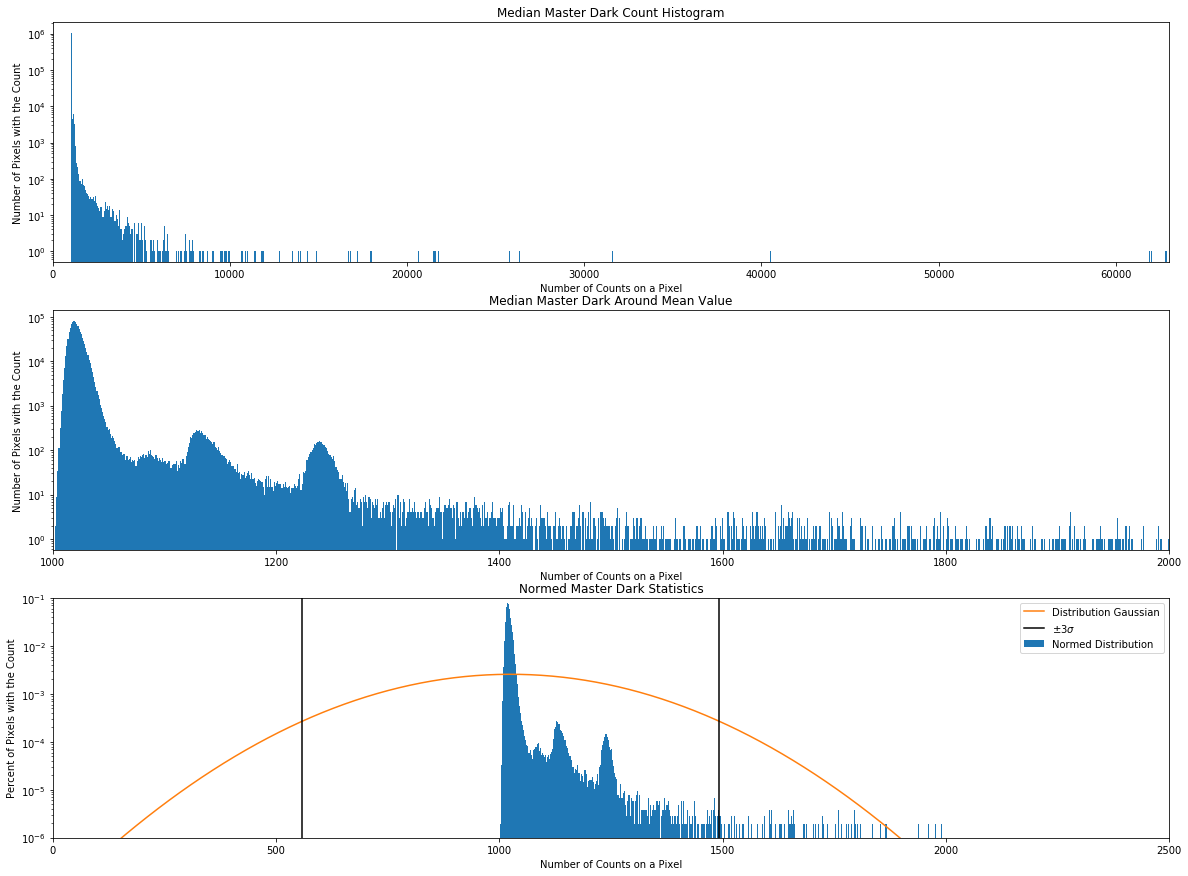

In [113]:
print('Range of count values: ', master_dark.min(), ' to ', master_dark.max())

# Plot Histograms
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
hist1 = ax1.hist(master_dark.flatten(), bins=1000, log=True)
hist2 = ax2.hist(master_dark.flatten(), bins=1001, log=True, range=(1000, 2000))
ax3.hist(master_dark.flatten(), bins=1001, log=True, range=(1000, 2000), density=True, label='Normed Distribution')
ax1.set_xlim(0, 63000)
ax2.set_xlim(1000, 2000)
ax1.set_title('Median Master Dark Count Histogram')
ax2.set_title('Median Master Dark Around Mean Value')
ax3.set_title('Normed Master Dark Statistics')
ax1.set_xlabel('Number of Counts on a Pixel')
ax2.set_xlabel('Number of Counts on a Pixel')
ax3.set_xlabel('Number of Counts on a Pixel')
ax1.set_ylabel('Number of Pixels with the Count')
ax2.set_ylabel('Number of Pixels with the Count')
ax3.set_ylabel('Percent of Pixels with the Count')


# Find statistics of master dark
mean1 = np.mean(master_dark.flatten())
median1 = np.median(master_dark.flatten())
mode1 = float(stats.mode(master_dark.flatten()).mode)
stddev1 = np.std(master_dark.flatten())
print('Mean: ', mean1, '\nMedian: ', median1, '\nMode: ', mode1, '\nStandard Deviation:', stddev1)

# Define a gaussian with the same statistics and overlay it on normed distribution
domain = np.linspace(-500, 3000, 1000)
gaussian = np.exp(-1*pow((domain - mean1)/(2*stddev1), 2))/pow(2*stddev1*stddev1*np.pi, 0.5)
ax3.plot(domain, gaussian, label='Distribution Gaussian')
ax3.axvline(x=mean1-3*stddev1, color='k', label=r'$\pm3\sigma$')
ax3.axvline(x=mean1+3*stddev1, color='k')
ax3.set_xlim(0, 2500)
ax3.set_ylim(10e-7, 0.1)
ax3.legend()

# Take the +/- 3 sigma value to use later
leftcutoff = mean1-3*stddev1
rightcutoff = mean1+3*stddev1

# Display plot
plt.show()

In [32]:
# How many pixels are out of the count uncertainty to 3 sigma and what fraction is that?
print('3 sigma range: ', leftcutoff, ' to ', rightcutoff)
master_dark_in_gaussian = [x for x in master_dark.flatten() if x<rightcutoff and x>leftcutoff] # Only take value in 
                                                                                               #  uncertainty range
print('Number of pixels out of 3 sigma range: ', len(master_dark.flatten())-len(master_dark_in_gaussian))
print('Percent of pixels in 3 sigma range: ', len(master_dark_in_gaussian)/len(master_dark.flatten()))

# Find statistics for 3 sigma cut
mean2 = np.mean(master_dark_in_gaussian)
median2 = np.median(master_dark_in_gaussian)
mode2 = float(stats.mode(master_dark_in_gaussian).mode)       # Specify to get just the value as a float, not unary list
stddev2 = np.std(master_dark_in_gaussian)
print('\nOld Statistics\nMean: ', mean1, '\nMedian: ', median1, '\nMode: ', mode1, '\nStandard Deviation:', stddev1)
print('\nNew Statistics\nMean: ', mean2, '\nMedian: ', median2, '\nMode: ', mode2, '\nStandard Deviation:', stddev2)

3 sigma range:  558.7816995516446  to  1492.1515966519687
Number of pixels out of 3 sigma range:  1212
Percent of pixels in 3 sigma range:  0.9988441467285156

Old Statistics
Mean:  1025.4666481018066 
Median:  1020.0 
Mode:  1019.0 
Standard Deviation: 155.56164951672068

New Statistics
Mean:  1023.0945912786767 
Median:  1020.0 
Mode:  1019.0 
Standard Deviation: 20.290142657098027


#### 2) Comparing master dark to a single dark frame

Using the found $3\sigma$ range above, a single dark frame that was used to make the master dark is analyzed. The whereas for the master dark, 1212 pixels fell out of the 99.8% undertainty range, for input frame 7, 1229 pixels fell out of the range. This corrosponds to $0.118\%$ of the pixels being hot or dead, instead of the $0.116\%$. The mean for this frame differs from the master by $$\textrm{% Difference}=\frac{\bar{x}_\textrm{frame}-\bar{x}_\textrm{master}}{\bar{x}_\textrm{master}}=-0.025\%.$$
The mean for this dark frame is $0.025\%$ lower than the mean for the master dark. Likewise we can find the percent difference in the standard deviation for frame 7 compared to the master dark to be $6.539\%$ higher.

These do not change by very much since we took the master dark to be the pixel-wise median average of the 10 input frames. Since each frame was taken under the same conditions, they would ideally all be identical if dark current was regular as opposed to probabilistic. Since it is probabilistic, no input frame is expected to hold the mean value for significantly more pixels than any other frame. This leads to the master dark distribution closely modelling the distribution of an input frame, with more accurately determined parameters.  

In [51]:
# Take the first dark frame, apply the same 3 sigma cutoff from master dark, what are stats?
input_dark = dark_list[6]
input_dark_cut = [x for x in input_dark.flatten() if x<rightcutoff and x>leftcutoff]
print('Number of pixels out of 3 sigma range: ', len(input_dark.flatten())-len(input_dark_cut))
print('Percent of pixels in 3 sigma range: ', len(input_dark_cut)/len(input_dark.flatten()))

mean3 = np.mean(input_dark_cut)
median3 = np.median(input_dark_cut)
mode3 = float(stats.mode(input_dark_cut).mode)       # Specify to get just the value as a float, not unary list
stddev3 = np.std(input_dark_cut)
print('\nCut Input Frame Statistics\nMean: ', mean3, '\nMedian: ', median3, 
      '\nMode: ', mode3, '\nStandard Deviation:', stddev3)
print('\nMaster Dark Statistics\nMean: ', mean2, '\nMedian: ', median2, 
      '\nMode: ', mode2, '\nStandard Deviation:', stddev2)

print('\nMean Diff: {0:4.3f}%'.format((mean3-mean2)/mean2*100))
print('StdDev Diff: {0:4.3f}%'.format((stddev3-stddev2)/stddev2*100))

Number of pixels out of 3 sigma range:  1229
Percent of pixels in 3 sigma range:  0.9988279342651367

Cut Input Frame Statistics
Mean:  1022.8360944367054 
Median:  1020.0 
Mode:  1019.0 
Standard Deviation: 21.616848464553968

Master Dark Statistics
Mean:  1023.0945912786767 
Median:  1020.0 
Mode:  1019.0 
Standard Deviation: 20.290142657098027

Mean Diff: -0.025%
StdDev Diff: 6.539%


#### 3) Dark current

#### 4) Dark current as a function of exposure time

# Check the calculation for error on the mean, way too small?
# Apply cut from before to eliminate crazy outliers?
# Variance equation for poisson distribution?

[1008.1024312973022, 1052.6718769073486, 1078.4408254623413, 1104.151312828064, 1129.9115056991577, 1155.4669942855835, 1181.077922821045, 1205.6167039871216, 1231.5160875320435, 1256.4830837249756]
[0.0958917540456731, 0.24432336862546566, 0.32668619134473303, 0.4020687475049772, 0.46258922011666204, 0.5159179643155658, 0.5777691047573948, 0.631809904704608, 0.6819862293130041, 0.7312467323380574]
Slope = 0.8637 +/- 0.0033
Intercept = 999.7099 +/- 0.2710


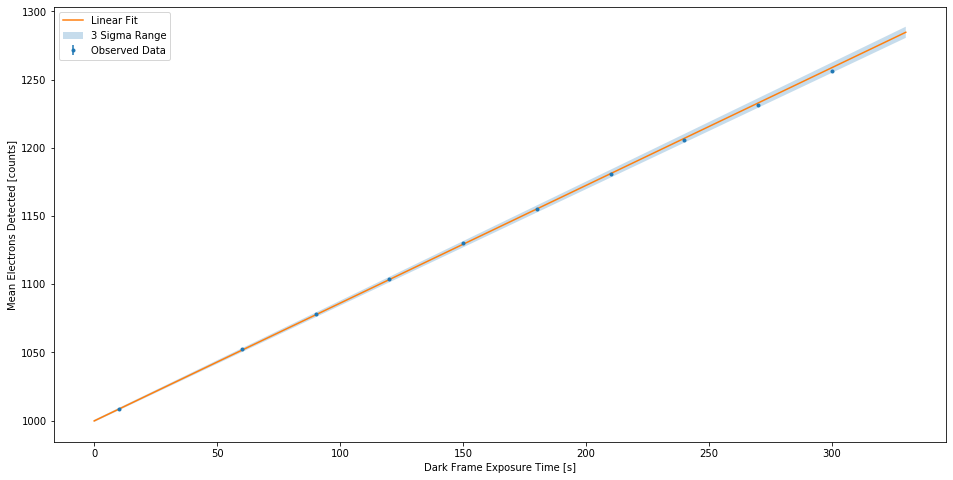

In [124]:
# Open all the files
dark0m10s = fits.open('../data/dark_series_0c_10s.00000001.DARK.FIT')
dark1m00s = fits.open('../data/dark_series_0c_1m.00000001.DARK.FIT')
dark1m30s = fits.open('../data/dark_series_0c_1m30s.00000001.DARK.FIT')
dark2m00s = fits.open('../data/dark_series_0c_2m.00000001.DARK.FIT')
dark2m30s = fits.open('../data/dark_series_0c_2m30s.00000001.DARK.FIT')
dark3m00s = fits.open('../data/dark_series_0c_3m.00000001.DARK.FIT')
dark3m30s = fits.open('../data/dark_series_0c_3m30s.00000001.DARK.FIT')
dark4m00s = fits.open('../data/dark_series_0c_4m.00000001.DARK.FIT')
dark4m30s = fits.open('../data/dark_series_0c_4m30s.00000001.DARK.FIT')
dark5m00s = fits.open('../data/dark_series_0c_5m.00000001.DARK.FIT')
dark_series = [dark0m10s, dark1m00s, dark1m30s, dark2m00s, dark2m30s,
               dark3m00s, dark3m30s, dark4m00s, dark4m30s, dark5m00s]

# Get list of mean counts and exposure times
means = []
exp_times = []
sig_on_mean = []
for file in dark_series:
    means.append(np.mean(file[0].data))
    sig_on_mean.append(np.std(file[0].data)/                  # Calculated with sig_xbar = sigma / sqrt(N)
                       np.sqrt(len(file[0].data.flatten())))
    exp_times.append(file[0].header['EXPTIME'])
print(means)
print(sig_on_mean)

# Close all the files
dark0m10s.close()
dark1m00s.close()
dark1m30s.close()
dark2m00s.close()
dark2m30s.close()
dark3m00s.close()
dark3m30s.close()
dark4m00s.close()
dark4m30s.close()
dark5m00s.close()

# Linear regression with y-axis errors
def line(x, a, b):
    return a*x+b

# Get optimal ab params and covar matrix, make it a function
popt, pcov = curve_fit(line, exp_times, means, sigma=sig_on_mean)
fit_err = np.sqrt(np.diag(pcov))
dark_current_function = np.poly1d(popt)
dark_current_lo = np.poly1d(popt - 3*fit_err)
dark_current_hi = np.poly1d(popt + 3*fit_err)

# Make the scatter plot with error bars
time = np.linspace(0, 330, 330)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.errorbar(exp_times, means, yerr=sig_on_mean, linestyle='none', marker='.', label='Observed Data')
ax1.set_xlabel('Dark Frame Exposure Time [s]')
ax1.set_ylabel('Mean Electrons Detected [counts]')
ax1.plot(time, dark_current_function(time), label='Linear Fit')
ax1.fill_between(time, dark_current_lo(time), dark_current_hi(time), alpha=0.25, label='3 Sigma Range')

print('Slope = {0:4.4f} +/- {1:4.4f}'.format(popt[0], fit_err[0]))
print('Intercept = {0:4.4f} +/- {1:4.4f}'.format(popt[1], fit_err[1]))


ax1.legend()
plt.show()

## 4.3: Imaging Flat Fields

## 4.4: Bad Pixel Map

## 4.6: Calibration Strategies